In [197]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate
import sys

In [2]:
def GetRMSE(x2, y2, x1, y1):
    from scipy.spatial.distance import pdist 

    er = []
    for idx in range(len(x2)):
        X = np.asarray([[x1[idx], y1[idx]], 
                         [x2[idx], y2[idx]]])
        temp_er = pdist(X,metric = 'euclidean')
        er.append(temp_er[0])
    er = np.asarray(er)
    return(er)

In [3]:
# parameters used to filter data

cutoff = 24

interpol_order = 3 # order for polynomial interpolation

# win_gauss = signal.gaussian(10,3) # gaussian kernal for smoothening interpolated data

# parameters for the savitzky-golay filter
savgol_win = 15
savgol_polyorder = 3

# window_length=7, polyorder=2,

ROLLING_WINDOW = [11, 21, 31][0]

### remove x y points based on threshold ( of rmse distance from previous frame ) 

In [4]:
direc = r"../dataFolders/PaperPipelineOutput/RawTracks/"
visitnum = 'FirstVisit/'

path = os.path.join(direc, visitnum)
trackslist = glob.glob(path + '*.csv')

In [167]:
name = 'c-2_m22_'
f = [file for file in trackslist if name in file]
f

['../dataFolders/PaperPipelineOutput/RawTracks/FirstVisit\\c-2_m22_visit_0.csv']

In [168]:
circ_parameters_path = glob.glob('../dataFolders/PaperPipelineOutput/CircleParameters/' + '*.csv')
circ_parameters = pd.read_csv(circ_parameters_path[0])

In [169]:
data = f[0]
name = os.path.basename(data)[:-4]
print(name)
file = pd.read_csv(data)
x = file.x.values
y = file.y.values
p = file.likelihood

x_notinView = x <=5
y_notinView = y <=5

x[x_notinView & y_notinView]=np.nan
y[x_notinView & y_notinView]=np.nan


# add filter for DLC likelihood
med = file['likelihood'].rolling(11).median()
x[med < 0.6] = np.nan
y[med < 0.6] = np.nan

if x.size == 0 or y.size == 0:
    print(name + 'has emtpy x y tracks')

c-2_m22_visit_0


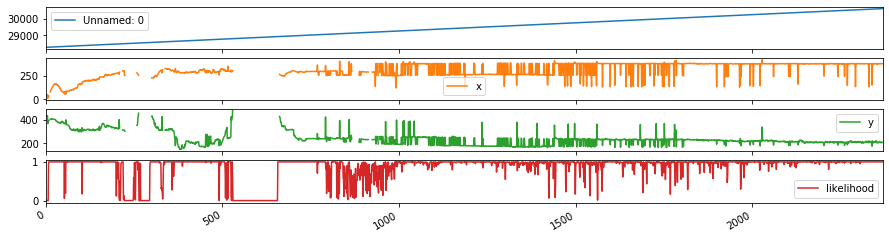

In [170]:
axes = file.plot(subplots=True, figsize=(15,4))

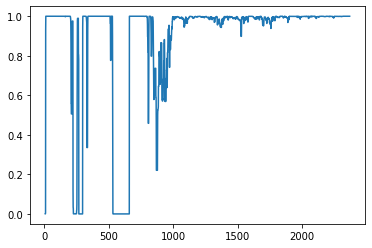

In [171]:
med = file['likelihood'].rolling(11).median()
plt.plot(med)

Text(0.5, 1.0, 'camera view')

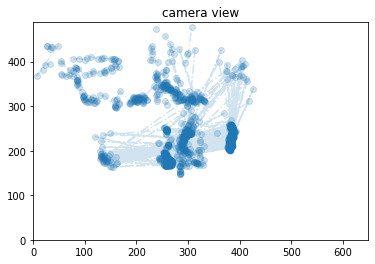

In [172]:
plt.plot(x,y, 'o-.', alpha = 0.2)
plt.xlim(0, 648)
plt.ylim(0,488)
plt.title('camera view')

In [173]:
name = [n for n in circ_parameters.name if n + '_' in f[0]][0]

circ_x = circ_parameters.loc[circ_parameters.name == name, 'circ_x'].values
circ_y = circ_parameters.loc[circ_parameters.name == name, 'circ_y'].values
circ_radii = circ_parameters.loc[circ_parameters.name == name, 'circ_radii'].values

In [174]:
cent_x = x - circ_x
cent_y = x - circ_y

r = np.linalg.norm([cent_x, cent_y], axis = 0)
r = r/circ_radii

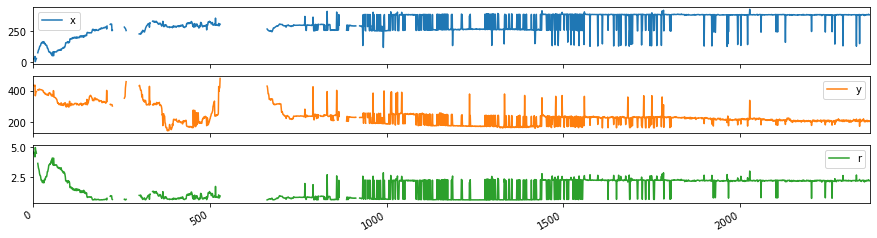

In [175]:
trajectory = pd.DataFrame([x, y, r]).T
trajectory.columns = ['x', 'y', 'r']
axes = trajectory.plot(subplots=True, figsize=(15,4))

In [176]:
# get rmse values for subsequent frames
rmse = GetRMSE(x[1:], y[1:], x[:-1], y[:-1])

filtered_x = np.copy(x[1:])
filtered_y = np.copy(y[1:])

filtered_x[(rmse > cutoff) | (rmse == np.nan)] = np.nan
filtered_y[(rmse > cutoff) | (rmse == np.nan)] = np.nan

filtered_r = np.linalg.norm([filtered_x - circ_x, filtered_y - circ_y], axis = 0)
filtered_r = filtered_r/circ_radii

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


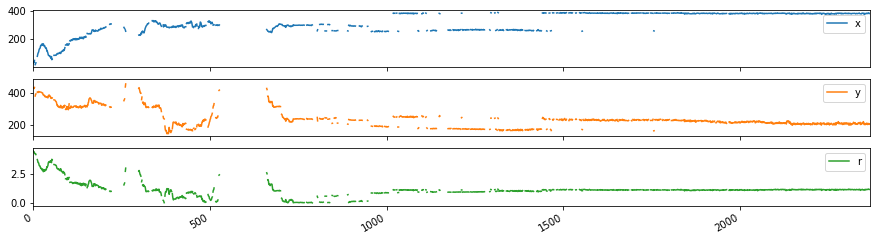

In [177]:
filt_trajectory = pd.DataFrame([filtered_x, filtered_y, filtered_r]).T
filt_trajectory.columns = ['x', 'y', 'r']
axes = filt_trajectory.plot(subplots=True, figsize=(15,4))

In [178]:
t = (pd.Series(filtered_x).rolling(30).median(center=True))
t_reverse = t[::-1]
t_reverse
s_end = np.argmax([ ~np.isnan(t) for t in r_reverse ] )
trim_end = len(t)-s

t_begin = (pd.Series(filtered_x).rolling(3).median(center=True))
s_begin = np.argmax([ ~np.isnan(t) for t in t_begin ] )
trim_begin = s_begin

In [179]:
s_begin

1

In [229]:
# Apply filters

trajectory = filt_trajectory.copy()
trajectory = trajectory.drop(['r'], axis = 1)
trajectory = trajectory.loc[trim_begin:trim_end, :]
print(trajectory.shape)

for colname in trajectory.columns:
    print(colname)
    trajectory.loc[:, colname] = signal.medfilt(trajectory.loc[:, colname], kernel_size=11)
#     trajectory.loc[:,colname] = trajectory.loc[:,colname].interpolate(method = 'polynomial', order = 3)
    trajectory.loc[:, colname] = trajectory.loc[:, colname].interpolate(method = 'polynomial', order = 3, limit = 40)
    nans = trajectory.loc[:,colname].isnull()
    trajectory.loc[:,colname] = trajectory.loc[:,colname].interpolate(method = 'pad')
#     trajectory.loc[:,colname] =  interpolate.interp1d(trajectory.loc[:,colname])
    trajectory.loc[:, colname] = signal.savgol_filter(trajectory.loc[:, colname],window_length=15,polyorder=3, axis=0)
    trajectory.loc[nans, colname]= np.nan

(2355, 2)
x
y


In [230]:
r = np.linalg.norm([trajectory.loc[:,'x'].values - circ_x, trajectory.loc[:,'y'].values - circ_y], axis = 0)
trajectory['r'] = r/circ_radii

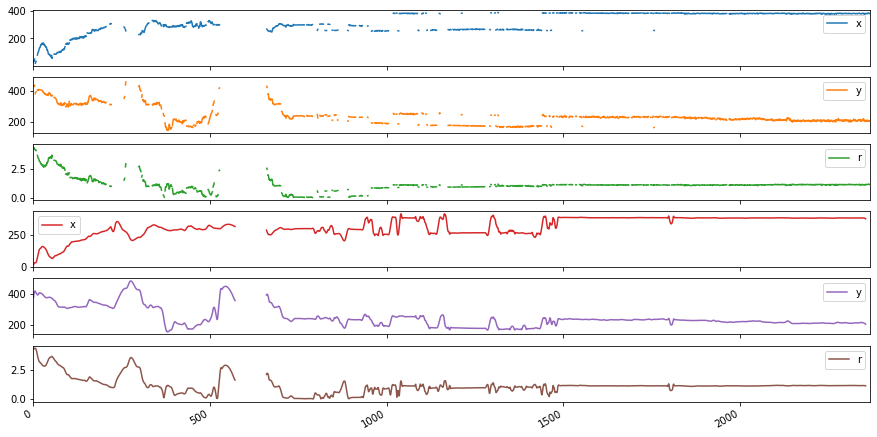

In [231]:
axes = pd.concat([filt_trajectory, trajectory], axis = 1).plot(subplots = True, figsize = (15,8))

In [ ]:


x_interpl = x.interpolate(method='polynomial', order=interpol_order)
y_interpl = y.interpolate(method='polynomial', order=interpol_order)

x_interpl = x_interpl[~np.isnan(x_interpl)]
y_interpl= y_interpl[~np.isnan(y_interpl)]

r_interpl = np.linalg.norm([x_interpl - circ_x, y_interpl - circ_y], axis = 0)
r_interpl = r_interpl/circ_radii

In [ ]:
_,ax = plt.subplots(3,1, figsize = (20,6))
ax[0].plot(x_interpl)
ax[1].plot(y_interpl)
ax[2].plot(r_interpl)
ax[2].set_xlabel('Frames')
plt.suptitle('interpolated Data')

In [ ]:
# savitzky-golay method for smoothening
x_savgol = signal.savgol_filter(x_interpl, savgol_win, savgol_polyorder)
y_savgol = signal.savgol_filter(y_interpl, savgol_win, savgol_polyorder)
r_savgol = np.linalg.norm([x_savgol- circ_x, y_savgol- circ_y], axis = 0)
r_savgol = r_savgol/circ_radii

In [ ]:
_,ax = plt.subplots(3,1, figsize = (20,6))
ax[0].plot(x_savgol)
ax[1].plot(y_savgol)
ax[2].plot(r_savgol)
ax[2].set_xlabel('Frames')
plt.suptitle('smoothened Data')

## I don't believe the last bit of the data, look at DLC confidence in that interval

In [ ]:
plt.scatter(np.arange(len(r_savgol)), r_savgol, c = file.likelihood[2:-1], cmap = plt.cm.cool )
plt.colorbar()

## Possible solution - use DLC likehood and remove points less than 0.4

In [ ]:
x = pd.Series(filtered_x)
y = pd.Series(filtered_y)

x_interpl = x.interpolate(method='polynomial', order=interpol_order)
y_interpl = y.interpolate(method='polynomial', order=interpol_order)

x_interpl = x_interpl[~np.isnan(x_interpl)]
y_interpl= y_interpl[~np.isnan(y_interpl)]

In [ ]:
plt.plot(x_interpl, y_interpl, 'o-')

## OHHH FUCK! 
### Should be using 2D interpolation, shouldn't I?

In [ ]:
# lets first look at DLC likelihood

# plt.scatter(np.arange(len(filtered_x)),filtered_x, c = file.likelihood[1:], cmap = plt.cm.cool)
# plt.show()

plt.scatter(filtered_x, filtered_y, c = file.likelihood[1:], cmap = plt.cm.cool)
plt.colorbar()

## get angle and magnitude

In [ ]:
def Unitvector(x_gauss, y_gauss):
    from sklearn import preprocessing
    
    # get the slope of the tangent
    trajectory = np.asarray([x_gauss, y_gauss])
    m = np.gradient(trajectory, axis = 1)
    m_atx = m[1]/m[0]
    
    # get the tangent vector at x = x0 + 1
    tangent_x = x_gauss+1
    tangent_y = m_atx + y_gauss
    
    # get the unit tangent vector
    u_x = []
    u_y = []

    for x,y,x0,y0 in zip(tangent_x, tangent_y, x_gauss, y_gauss):
        if np.any(np.isnan([x, y])) or np.any(np.isinf([x, y])):
            unit_x = np.nan
            unit_y = np.nan
        else:
            vector = np.asarray([x-x0, y-y0]).reshape(1,-1)
            [unit_x, unit_y] = preprocessing.normalize(vector, norm = 'l2')[0]
        u_x.append(unit_x)
        u_y.append(unit_y)
    u_x = np.asarray(u_x)
    u_y = np.asarray(u_y)
    return(u_x, u_y)

def getAngle(loc, tangent):
    cross = np.cross(tangent, loc)
    dot = np.dot(tangent, loc)
    angle = np.arctan2(cross, dot)*180/np.pi
    return(angle)

def wrapAngle(angle):
    angle = np.absolute(angle)
    for i,a in enumerate(angle):
        if a > 90:
            a = 180 - a
            angle[i] = a
    return(angle)

In [ ]:
r = np.linalg.norm([x_interpl, y_interpl], axis = 0)
r = r/circ_radii

# savitzky-golay method
x_savgol = signal.savgol_filter(x_interpl, savgol_win, savgol_polyorder)
y_savgol = signal.savgol_filter(y_interpl, savgol_win, savgol_polyorder)
r_savgol = np.linalg.norm([x_savgol, y_savgol], axis = 0)
r_savgol_norm = r_savgol/circ_radii

# save all usable variables as series

df1 = pd.Series(data = x_savgol, name = 'x_savgol')
df2 = pd.Series(data = y_savgol, name = 'y_savgol')
df3 = pd.Series(data = r_savgol_norm, name = 'radial distance savgol')


#calculate the unit tangent vectors - savitzky-golay vector
u_x, u_y = Unitvector(x_savgol, y_savgol)

angle_savgol = []
for x0, y0, x, y in zip(x_savgol, y_savgol, u_x, u_y):
    loc = [x0, y0]
    tangent = [x, y]
    a = getAngle(loc, tangent)
    angle_savgol.append(a)

angle_savgol = wrapAngle(angle_savgol)

df4 = pd.Series(data = angle_savgol, name = 'angle_savgol')
       
#         new_file = pd.concat([file, df1, df2, df3, df4], axis = 1)
#         new_file.to_csv(newpath + name + 'RadiusAndAngle.csv', index_label = False)